#### import required library

Dataset link: "https://www.kaggle.com/datasets/shantanudhakadd/email-spam-detection-dataset-classification"

In [1]:
# uncomment the following line to install required libraries
# !pip install numpy pandas seaborn matplotlib scikit-learn nltk wordcloud kagglehub

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import kagglehub
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

/home/lap962per/miniconda3/envs/practice/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download latest version
try:
    path = kagglehub.dataset_download("shantanudhakadd/email-spam-detection-dataset-classification")
    print("Path to dataset files:", path)
except Exception as e:
    print(e)

Path to dataset files: /home/lap962per/.cache/kagglehub/datasets/shantanudhakadd/email-spam-detection-dataset-classification/versions/1


In [4]:
# reading dataset
df=pd.read_csv(path+'/spam.csv',encoding='ISO-8859-1')

In [5]:
# dataset sample
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5169,ham,Now i'm going for lunch.,NaN,NaN,NaN
192,ham,Hi :)finally i completed the course:),NaN,NaN,NaN
1437,ham,Wat so late still early mah. Or we juz go 4 di...,NaN,NaN,NaN
4199,ham,I will come tomorrow di,NaN,NaN,NaN
5449,spam,"Latest News! Police station toilet stolen, cop...",NaN,NaN,NaN


In [6]:
# dataset shape
df.shape

(5572, 5)

In [7]:
# 1. Data cleaning
# 2. EDA
# 3. Text preproccessing
# 4. Model building
# 5. Evaluation
# 6. Improvment

## 1. Data Cleaning

In [8]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [9]:
# null values in dataset
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [10]:
# drop last 3 columns becouse they are unused 
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [11]:
# dataset 
df.sample(4)

,v1,v2
3212,ham,What's ur pin?
2100,ham,Oh Howda gud gud.. Mathe en samachara chikku:-)
4275,ham,Can you please send me my aunty's number
5447,ham,So that takes away some money worries


In [12]:
# Renaming the columns name
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [13]:
df.sample(4)

,target,text
2320,ham,This pain couldn't have come at a worse time.
5168,ham,"IÛ÷ve got some salt, you can rub it in my ope..."
3052,ham,Pls send me the correct name da.
1805,ham,God bless.get good sleep my dear...i will pray!


In [14]:
#label encoding on target columns to convert spam to 1 and ham to 0
encoder=LabelEncoder()
df['target']=encoder.fit_transform(df['target'])

In [15]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [17]:
# check duplicates values
df.duplicated().sum()

np.int64(403)

- there is 403 dublicated values

In [18]:
#  removing duplicated values
df=df.drop_duplicates()

In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
#check dataset's shape after removing duplicates values
df.shape

(5169, 2)

## 2. Exploratory Data Analysis

In [21]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

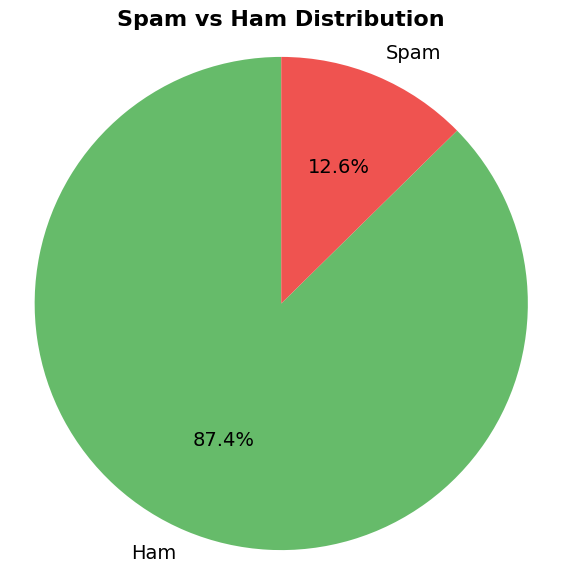

In [22]:
# spam vs ham distribution
labels = ['Ham', 'Spam']
sizes = df['target'].value_counts().sort_index()
colors = ['#66bb6a', '#ef5350']

fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14, 'color': 'black'}
)
ax.axis('equal')

plt.title("Spam vs Ham Distribution", fontsize=16, fontweight='bold')
plt.show()


* Data is highly imbalanced, need to do the balancing the data for better model performance

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/lap962per/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
# numbers of characters
df['num_characters']=df['text'].apply(len)

In [25]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [26]:
#count number of words
df['num_words']=df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [ ]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [28]:
# count number of sentences
df['num_sentences']=df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [29]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [30]:
df.describe()

,target,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


- around 78 words uses in per email, around 18 words uses in per email and around 2 sentences uses for per emails

In [31]:
# ham
df[df['target']==0].describe()

,target,num_characters,num_words,num_sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


- for ham emails around 70 words uses in per email, around 17 words uses in per email and around 1.8 sentences uses for per emails

In [32]:
# spam emails
df[df['target']==1].describe()

,target,num_characters,num_words,num_sentences
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.970904
std,0.0,30.137753,7.008418,1.488425
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


- for spam emails around 137 words uses in per email, around 27 words uses in per email and around 3 sentences uses for per emails. it can be conclude that spam emails generally larger than ham emails

In [33]:
# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [34]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [35]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [36]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [37]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [38]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [39]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


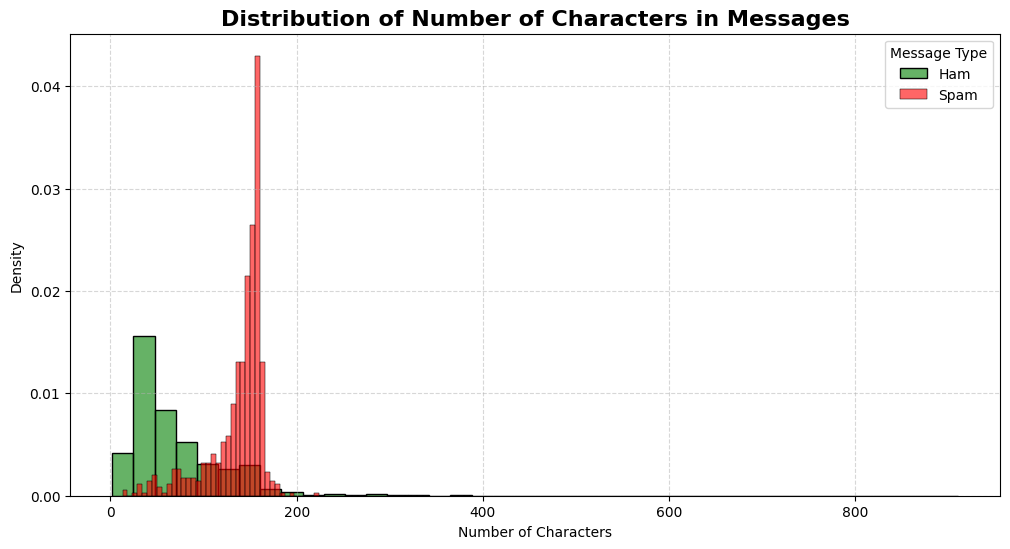

In [ ]:
# distribution of Number of Characters in Messages
plt.figure(figsize=(12,6))

sns.histplot(df[df['target'] == 0]['num_characters'], 
             color='green', label='Ham', kde=False, stat='density', alpha=0.6, bins=40)
sns.histplot(df[df['target'] == 1]['num_characters'], 
             color='red', label='Spam', kde=False, stat='density', alpha=0.6, bins=40)

plt.title('Distribution of Number of Characters in Messages', fontsize=16, fontweight='bold')
plt.xlabel('Number of Characters')
plt.ylabel('Density')
plt.legend(title='Message Type')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


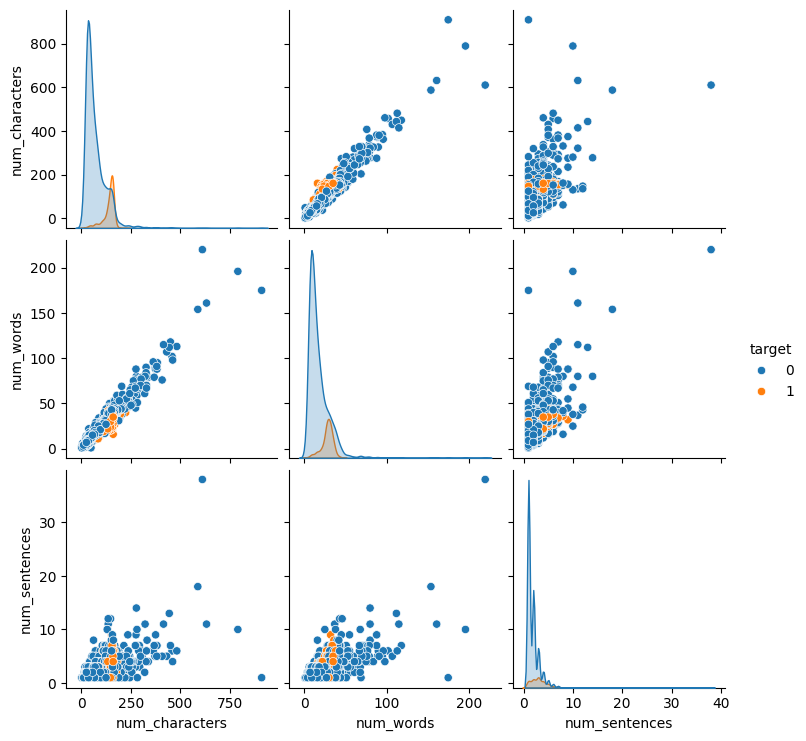

In [41]:
sns.pairplot(df,hue='target')

In [42]:
df.drop(columns=['text']).corr()

,target,num_characters,num_words,num_sentences
target,1.000000,0.384717,0.262912,0.263939
num_characters,0.384717,1.000000,0.965760,0.624139
num_words,0.262912,0.965760,1.000000,0.679971
num_sentences,0.263939,0.624139,0.679971,1.000000


<Axes: >

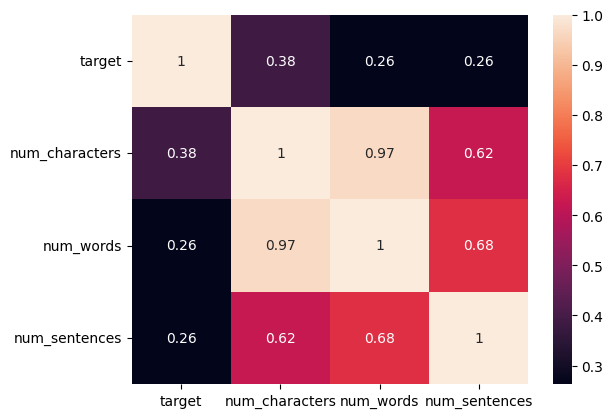

In [43]:
sns.heatmap(df.drop(columns=['text']).corr(),annot=True)

## 3. Data Preprocessing
- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [44]:
# Text transformation function
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [45]:
ps = PorterStemmer()
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [46]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [47]:
ps.stem('loving')

'love'

In [48]:
df['transformed_text'] = df['text'].apply(transform_text)

In [49]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [50]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [51]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

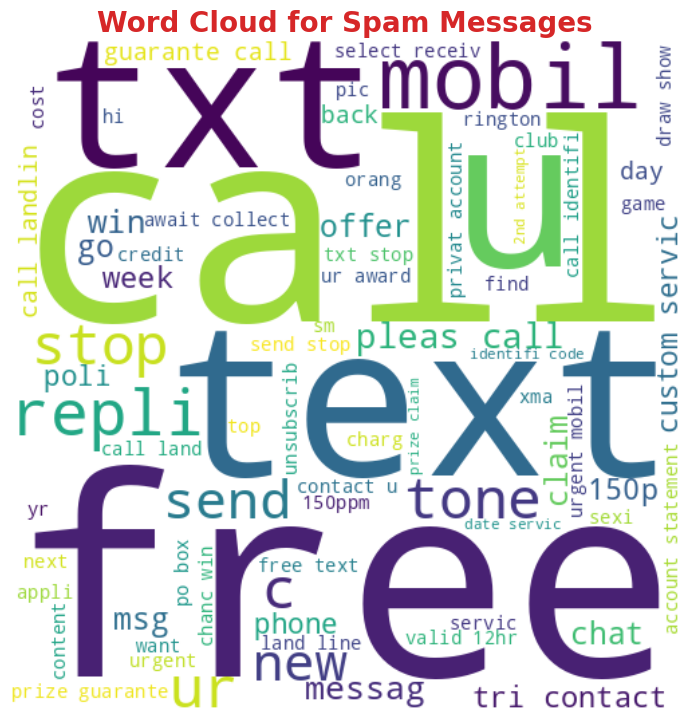

In [ ]:
plt.figure(figsize=(7, 8))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages', fontsize=20, fontweight='bold', color='#d62728')  # red title
plt.tight_layout()
plt.show()

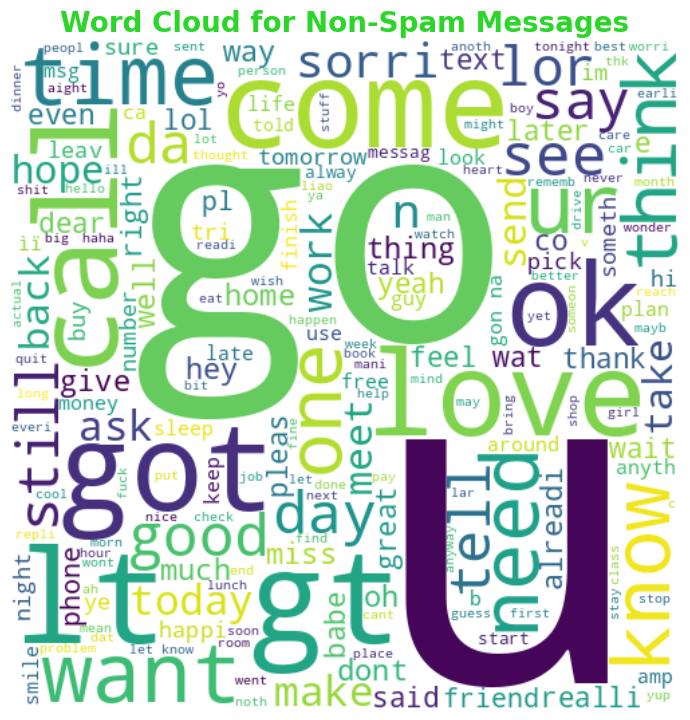

In [ ]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(7, 8))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Spam Messages', fontsize=20, fontweight='bold', color="#2ad627")  # red title
plt.tight_layout()
plt.show()

In [54]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [55]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
        

In [56]:
len(spam_corpus)

9939

In [57]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [ ]:
len(ham_corpus)

35404

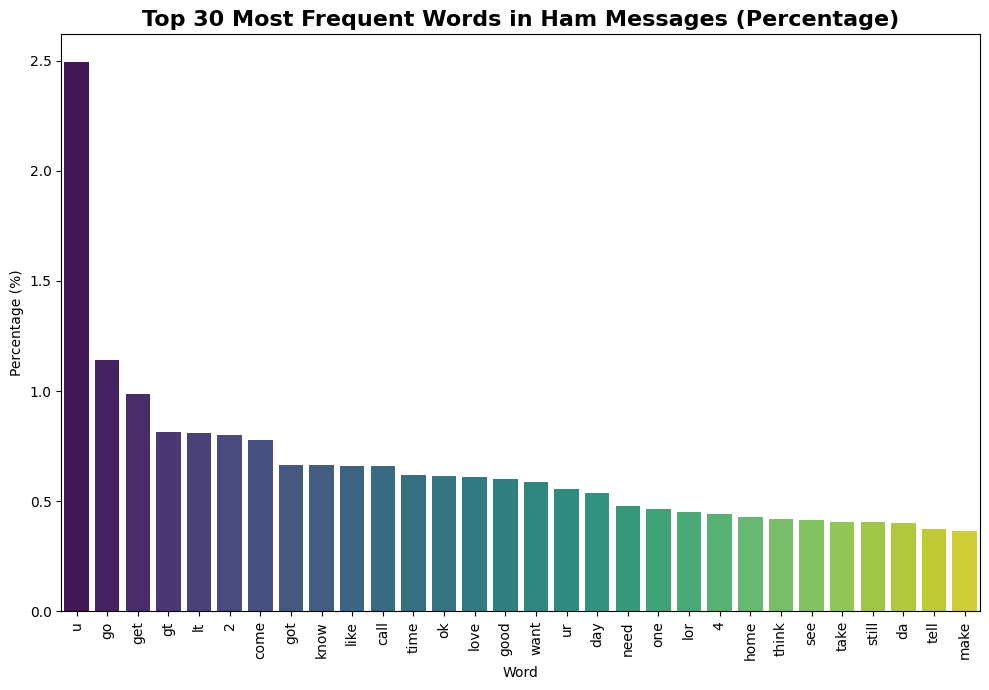

In [ ]:
# calculate total words in ham_corpus
total_words = len(ham_corpus)
item_counts = Counter(ham_corpus)

# get most common 30 words with counts
most_common_items = item_counts.most_common(30)

# convert counts to percentages
items = [item for item, count in most_common_items]
counts = [count for item, count in most_common_items]
percentages = [(count / total_words) * 100 for count in counts]

# create DataFrame with percentage
df_item = pd.DataFrame({
    'Item': items,
    'Percentage': percentages
})

# sort by percentage descending
df_item = df_item.sort_values(by='Percentage', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Item', y='Percentage', data=df_item, palette='viridis')

plt.xticks(rotation=90)
plt.ylabel('Percentage (%)')
plt.xlabel('Word')
plt.title('Top 30 Most Frequent Words in Ham Messages (Percentage)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


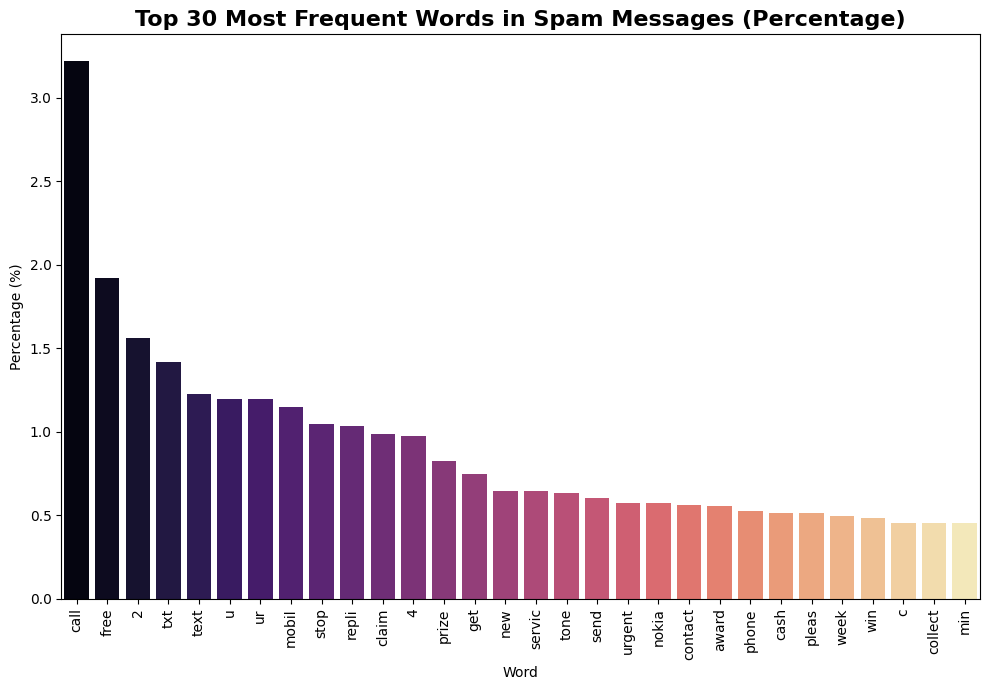

In [ ]:
# calculate total words in spam_corpus
total_words_spam = len(spam_corpus)
item_counts = Counter(spam_corpus)

# get most common 30 words with counts
most_common_spam = item_counts.most_common(30)

# extract words and counts
items_spam = [item for item, count in most_common_spam]
counts_spam = [count for item, count in most_common_spam]

# convert counts to percentages
percentages_spam = [(count / total_words_spam) * 100 for count in counts_spam]

# create DataFrame with percentages
df_spam = pd.DataFrame({
    'Item': items_spam,
    'Percentage': percentages_spam
})

# sort by percentage descending
df_spam = df_spam.sort_values(by='Percentage', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Item', y='Percentage', data=df_spam, palette='magma')

plt.xticks(rotation=90)
plt.ylabel('Percentage (%)')
plt.xlabel('Word')
plt.title('Top 30 Most Frequent Words in Spam Messages (Percentage)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [61]:
# Text Vectorization
# using Bag of Words
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


## 4. Data balancing and Model Building

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# list of 7 different models
model_list = [
    MultinomialNB(),
    LogisticRegression(solver='liblinear'),
    DecisionTreeClassifier(max_depth=5),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=50, random_state=2),
    SVC(kernel='linear', probability=True),
    BernoulliNB()
]
ham = df[df['target'] == 0]
spam = df[df['target'] == 1]

# split ham into 7 equal parts for each model and then concatenate with spam to create 7 balanced datasets
ham_splits = np.array_split(ham, 7)

models = []
vectorizers = []

# train each model on one balanced dataset
for i in range(7):
    balanced_df = pd.concat([ham_splits[i], spam]).sample(frac=1).reset_index(drop=True)

    tfidf = TfidfVectorizer(max_features=3000)
    X = tfidf.fit_transform(balanced_df['transformed_text']).toarray()
    y = balanced_df['target'].values

    clf = model_list[i]
    clf.fit(X, y)

    models.append(clf)
    vectorizers.append(tfidf)

print("Trained 7 different models on 7 balanced datasets.")


Trained 7 different models on 7 balanced datasets.


In [63]:
# =======================
# MAJORITY VOTING FUNCTION
# =======================

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)

def predict_with_majority_voting(text):
    transformed = transform_text(text)
    votes = []
    for i in range(7):
        vec = vectorizers[i].transform([transformed]).toarray()
        pred = models[i].predict(vec)[0]
        votes.append(pred)
        
    print("votes", votes)
    
    final_pred = 1 if votes.count(1) >= 4 else 0
    return final_pred


votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
votes [np.int64(0), 

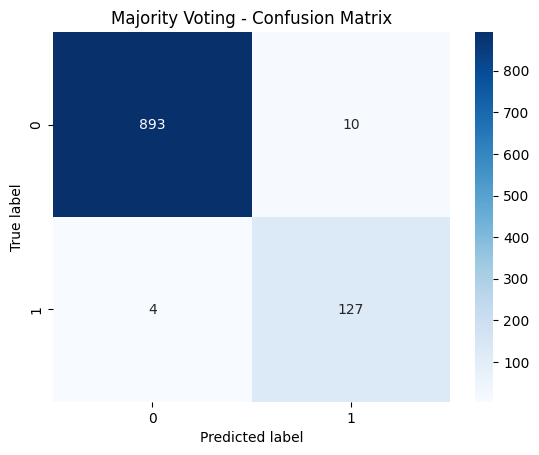

In [ ]:
# prepare a separate test set (stratified split)
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['target'], test_size=0.2, random_state=42, stratify=df['target']
)

# predict using majority voting
y_pred_mv = []
for text in X_test:
    y_pred_mv.append(predict_with_majority_voting(text))

# evaluate
acc = accuracy_score(y_test, y_pred_mv)
prec = precision_score(y_test, y_pred_mv)
cm = confusion_matrix(y_test, y_pred_mv)

print(f"Majority Voting Accuracy: {acc:.4f}")
print(f"Majority Voting Precision: {prec:.4f}")
print("Confusion Matrix:\n", cm)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Majority Voting - Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [70]:
print(f"Majority Voting Accuracy: {acc:.4f}")
print(f"Majority Voting Precision: {prec:.4f}")
print("Confusion Matrix:\n", cm)

Majority Voting Accuracy: 0.9913
Majority Voting Precision: 0.9766
Confusion Matrix:
 [[893  10]
 [  4 127]]


In [65]:
# save all 7 models and vectorizers
for i in range(7):
    pickle.dump(models[i], open(f'model_{i}.pkl', 'wb'))
    pickle.dump(vectorizers[i], open(f'vectorizer_{i}.pkl', 'wb'))


In [66]:
text = "he brother how are you , what you are doing in there day? do you remember those colleagues from last year?"
result = predict_with_majority_voting(text)
print("Prediction:", "Spam" if result == 1 else "Ham")


votes [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Prediction: Ham


In [67]:
results = []

for i in range(7):
    tfidf = vectorizers[i]
    model = models[i]
    
    X_test_tfidf = tfidf.transform(X_test.apply(transform_text)).toarray()
    
    start = time.time()
    y_pred = model.predict(X_test_tfidf)
    end = time.time()
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    duration = end - start
    
    results.append({
        'Model': type(model).__name__,
        'Accuracy (%)': round(acc * 100, 2),
        'Precision (%)': round(prec * 100, 2),
        'F1 Score (%)': round(f1 * 100, 2),
        'Inference Time (s)': round(duration, 4)
    })

results_df = pd.DataFrame(results)
print(results_df)


                    Model  Accuracy (%)  Precision (%)  F1 Score (%)  \
0           MultinomialNB         94.68          70.88         82.43   
1      LogisticRegression         96.52          81.88         87.14   
2  DecisionTreeClassifier         89.75          56.68         66.67   
3    KNeighborsClassifier         94.78          98.73         74.29   
4  RandomForestClassifier         98.45          89.12         94.24   
5                     SVC         97.39          82.91         90.66   
6             BernoulliNB         99.13          97.66         96.53   

   Inference Time (s)  
0              0.0033  
1              0.0074  
2              0.0071  
3              0.0720  
4              0.0353  
5              1.0231  
6              0.0138  


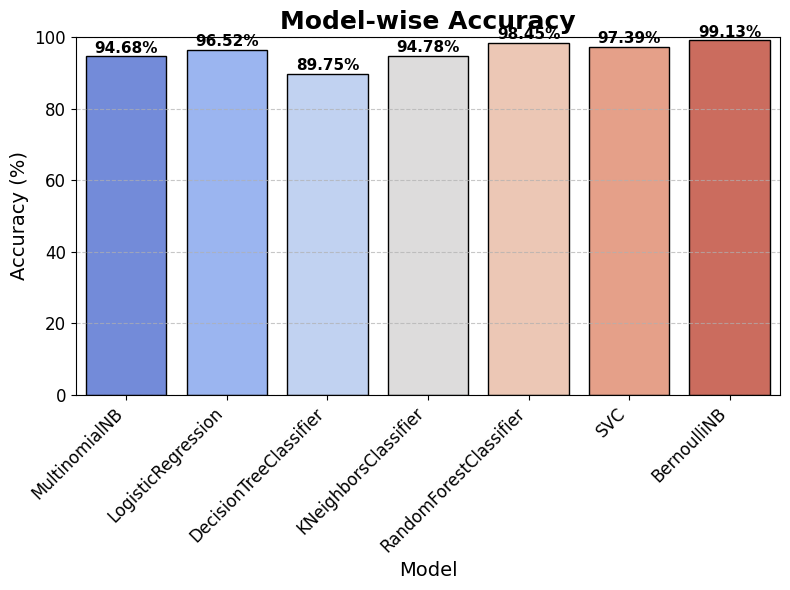

In [ ]:
plt.figure(figsize=(8, 6))

sns.barplot(
    data=results_df,
    x='Model',
    y='Accuracy (%)',
    palette='coolwarm',
    edgecolor='black'
)

plt.title('Model-wise Accuracy', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, 100)  # Assuming accuracy is in percentage scale 0-100

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add accuracy values on top of bars
for index, row in results_df.iterrows():
    plt.text(
        index, 
        row['Accuracy (%)'] + 1,  # slightly above the bar
        f"{row['Accuracy (%)']:.2f}%", 
        ha='center', 
        fontsize=11,
        fontweight='bold'
    )

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [69]:
print("Majority Voting Performance Report:\n")
print(classification_report(y_test, y_pred_mv, target_names=['Ham', 'Spam']))


Majority Voting Performance Report:

              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99       903
        Spam       0.93      0.97      0.95       131

    accuracy                           0.99      1034
   macro avg       0.96      0.98      0.97      1034
weighted avg       0.99      0.99      0.99      1034

